<a href="https://colab.research.google.com/github/Gyeong-Hyeon/Hyunie_Programming/blob/main/2021Dev-Matching/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D%20%EA%B3%BC%EC%A0%9C%ED%85%8C%EC%8A%A4%ED%8A%B8_%EC%97%BC%EA%B2%BD%ED%98%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<전체 내용 요약>

## 데이터 부분


---


* class 별 이미지 숫자를 뽑아 보았을 때 가장 숫자가 적은 class(guitar)와 많은 class(person) 사이에 약 2배가량 train image 개수 차이가 나는 것을 확인 했습니다.
따라서 validation set moniter시 **f1 score**도 함께 평가했으나, epoch별 변화를 보았을 때, accuracy 변화와 크게 다른 양상을 보이지 않았습니다.

## 모델 build 부분


---



* 처음에 base line 설정을 위해 간단한 convolution 모델을 구현하여 평가를 하였습니다.

* 두 번째로 resnet 모델 구조를 차용한 모델을 build 했습니다. Resnet을 사용한 이유는, convolution layer의 특성상 shape보다 color와 질감에 의해 class를 구분하도록 학습됩니다. 하지만 해당 train set은 사진이 아닌 그림이므로 shape의 특성도 중요하게 반영되어야 한다고 생각했기 때문에 원본의 특성을 최대한 반영시키는 skip connection을 가지고 있는 resnet 구조를 차용했습니다. 처음부터 resnet 전이학습을 사용하지않은 이유는, 기존에 훈련된 imagenet weight가 컬러 사진을 기준으로 훈련되었기 때문에 원색이 많이 사용되고 입체감이 없는 그림과는 많이 상이할 것으로 판단했기 때문입니다.

* 세 번재로는 resnet모델의 weight를 imagenet으로 셋팅하고 전체 layer를 train data로 fine tuning했습니다.
Resnet50과 152v2 모두 사용해 보았고, validation f1 score에서 resnet50이 resnet152v2보다 성능이 좋은 것으로 확인했습니다.

 이렇게 여러 방법을 시도해 보았으나, 손으로 build한 baseline 신경망의 성능이 가장 높은 것을 확인했습니다. 따라서 해당 모델에서 conv layer를 더 build하고, keras tuner를 사용하여 하이퍼 파라미터를 조정하는 방법으로 모델의 성능을 조금 더 올릴 수 있을 것으로 기대됩니다.

#<해결 과정>


##1. 데이터 준비

In [ ]:
!unzip /content/drive/MyDrive/Devmatch/train.zip

In [1]:
#라이브러리 임포트
import os
import matplotlib.pyplot as plt
import skimage.io
import numpy as np

In [2]:
#기본 변수 설정
categories = ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']
n_categories = len(categories)
category_embeddings = {
    'dog':0,
    'elephant':1,
    'giraffe':2,
    'guitar':3,
    'horse':4,
    'house':5,
    'person':6
}
width,height,channel = 227,227,3

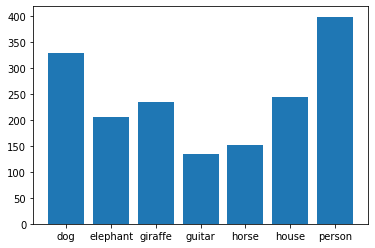

In [ ]:
n_imgs = []
for cat in categories:
    files = os.listdir(os.path.join('train', cat))
    n_imgs += [len(files)]
    
plt.bar([_ for _ in range(n_categories)], n_imgs, tick_label=categories)
plt.show()

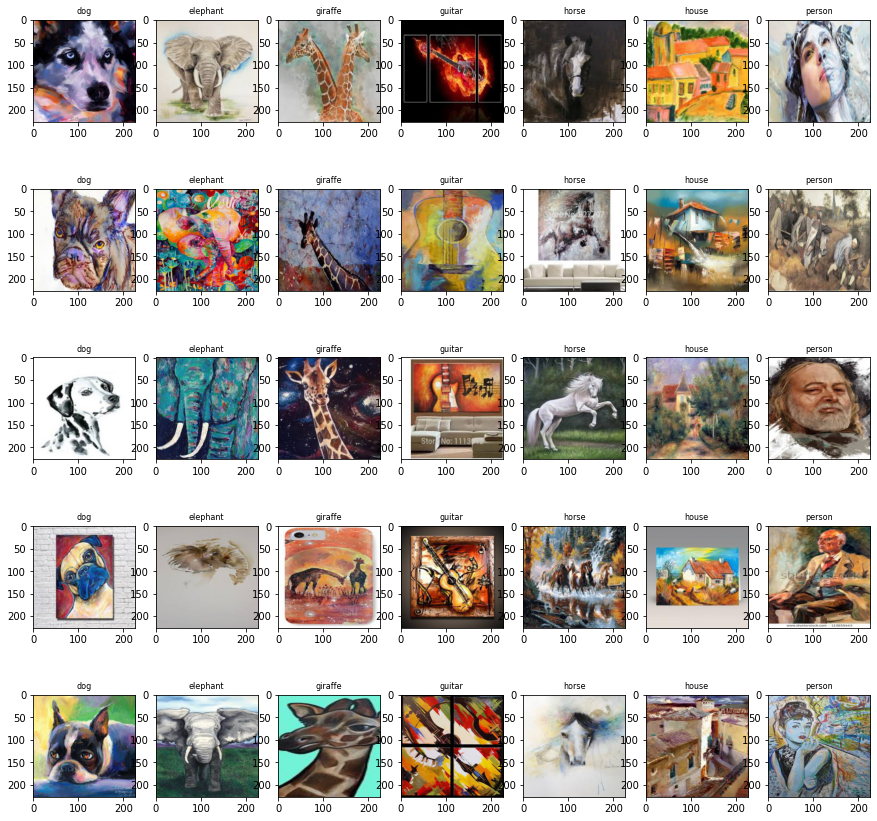

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=n_categories, figsize=(15, 15))

cat_cnt=0
for cat in categories:
  category_path = os.path.join('train', cat)
  img_cnt=0
  while img_cnt < 5:
      img_name = os.listdir(category_path)[img_cnt]
      img = skimage.io.imread(os.path.join(category_path, img_name))
      axes[img_cnt][cat_cnt].imshow(img)
      axes[img_cnt][cat_cnt].set_title(cat, fontsize=8)
      img_cnt+=1
  cat_cnt+=1     
#plt.show()

In [3]:
#dataset load 함수
def load_dataset(tuples_list, dataset_path):
    indexes = np.arange(len(tuples_list))
    np.random.shuffle(indexes)
    
    X = []
    y = []
    n_samples = len(indexes)
    cpt = 0
    for i in range(n_samples):
        t = tuples_list[indexes[i]]
        try:
            img = skimage.io.imread(os.path.join(dataset_path, t[0]))
            X += [img]
            y_tmp = [0 for _ in range(n_categories)]
            y_tmp[category_embeddings[t[1]]] = 1
            y += [y_tmp]
        except OSError:
            pass
        
        cpt += 1
        
        if cpt % 1000 == 0:
            print("Processed {} images".format(cpt))

    X = np.array(X)/255
    y = np.array(y)
    
    return X, y

data = []
for cat in categories:
    files = os.listdir(os.path.join('train', cat))
    for file in files:
        data += [(os.path.join(cat, file), cat)]

X, y = load_dataset(data, 'train')
print(X.shape, y.shape)

Processed 1000 images
(1698, 227, 227, 3) (1698, 7)


##2-1. Baseline Model

In [ ]:
!pip install -U keras-tuner
import kerastuner as kt
from sklearn.model_selection import GridSearchCV

In [5]:
#라이브러리 임포트
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, experimental
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [ ]:
#seed 고정
np.random.seed(10)
tf.random.set_seed(10)

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    horizontal_flip=True,
    validation_split=0.1)

train_datagen.fit(X)

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=5, input_shape=(width, height, channel), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(48, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.35))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(n_categories, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 223, 223, 32)      2432      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 109, 109, 48)      13872     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 54, 54, 48)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 54, 54, 48)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 139968)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)              

In [ ]:
model_path = "/content/model/Baseline" + '{epoch:04d}-{val_loss:.4f}.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_path,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1)

In [ ]:
batch_size=32
epochs=100

train_generator = train_datagen.flow(X, y, batch_size=32, subset='training')
validation_generator = train_datagen.flow(X, y, batch_size=32, subset='validation')

model.fit_generator(
    train_generator,
    validation_data = validation_generator,
    epochs = epochs,
    callbacks=[model_checkpoint_callback])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
43/43 [==============================] - 16s 350ms/step - loss: 5.6471 - accuracy: 0.1754 - val_loss: 1.8606 - val_accuracy: 0.2684

Epoch 00001: val_loss improved from inf to 1.86060, saving model to /content/model/Baseline0001-1.8606.h5
Epoch 2/100
43/43 [==============================] - 15s 343ms/step - loss: 1.9042 - accuracy: 0.2184 - val_loss: 1.9289 - val_accuracy: 0.2684

Epoch 00002: val_loss did not improve from 1.86060
Epoch 3/100
43/43 [==============================] - 15s 343ms/step - loss: 1.9179 - accuracy: 0.2204 - val_loss: 1.8783 - val_accuracy: 0.2802

Epoch 00003: val_loss did not improve from 1.86060
Epoch 4/100
43/43 [==============================] - 15s 346ms/step - loss: 1.8862 - accuracy: 0.2366 - val_loss: 1.8298 - val_accuracy: 0.2861

Epoch 00004: val_loss improved from 1.86060 to 1.82980, saving model to /content/model/Baseline0004-1.8298.h5
Epoch 5/100
43/43 [==============================] - 15s 338ms/step - loss: 1.8664 - accuracy: 0.2276 

##2-2. Resnet 구조 차용

In [38]:
from keras import backend as K

def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall

def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision

def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score

In [ ]:
class conv_block(tf.keras.Model):
    def __init__(self, filters, strides=(2, 2)):
        super(conv_block, self).__init__()

        self.filters1, self.filters2, self.filters3 = filters
        self.strides = strides

        self.conv1 = tf.keras.layers.Conv2D(self.filters1, (1, 1), strides=strides)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.relu1 = tf.keras.layers.ReLU()

        self.conv2 = tf.keras.layers.Conv2D(self.filters2, (3, 3), strides=(1, 1), padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.relu2 = tf.keras.layers.ReLU()

        self.conv3 = tf.keras.layers.Conv2D(self.filters3, (1, 1), strides=(1, 1))
        self.bn3 = tf.keras.layers.BatchNormalization()

        self.shortcut_conv = tf.keras.layers.Conv2D(self.filters3, (1, 1), strides=strides)
        self.shortcut_bn = tf.keras.layers.BatchNormalization()

        self.add = tf.keras.layers.Add()
        self.add_relu = tf.keras.layers.ReLU()


    def call(self, input_tensor, training=False):
        x = self.conv1(input_tensor)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.conv3(x)
        x = self.bn3(x)

        shortcut = self.shortcut_conv(input_tensor)
        shortcut = self.shortcut_bn(shortcut)

        x = self.add([x, shortcut])
        x = self.add_relu(x)

        return x
        


class identity_block(tf.keras.Model):
    def __init__(self, filters):
        super(identity_block, self).__init__()

        self.filters1, self.filters2, self.filters3 = filters

        self.conv1 = tf.keras.layers.Conv2D(self.filters1, (1, 1), strides=(1, 1))
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.relu1 = tf.keras.layers.ReLU()

        self.conv2 = tf.keras.layers.Conv2D(self.filters2, (3, 3), strides=(1, 1), padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.relu2 = tf.keras.layers.ReLU()

        self.conv3 = tf.keras.layers.Conv2D(self.filters3, (1, 1), strides=(1, 1))
        self.bn3 = tf.keras.layers.BatchNormalization()
        
        self.add = tf.keras.layers.Add()
        self.add_relu = tf.keras.layers.ReLU()

    
    def call(self, input_tensor, training=False):
        x = self.conv1(input_tensor)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.conv3(x)
        x = self.bn3(x)

        x = self.add([x, input_tensor])
        x = self.add_relu(x)

        return x




    
class ResNet50(tf.keras.Model):
    def __init__(self, n_classes):
        super(ResNet50, self).__init__()

        self.n_classes = n_classes

        # Stage 1 (Conv1 Layer)
        self.zero_padd_1_1 = tf.keras.layers.ZeroPadding2D(padding=(3, 3))
        self.conv_1 = tf.keras.layers.Conv2D(64, (7, 7), strides=(2, 2))
        self.bn_1 = tf.keras.layers.BatchNormalization()
        self.relu_1 = tf.keras.layers.ReLU()
        self.zero_padd_1_2 = tf.keras.layers.ZeroPadding2D(padding=(1, 1))
        self.max_pool = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2))

        # Stage 2
        self.stage2 = tf.keras.Sequential()
        self.stage2.add(conv_block([64, 64, 256], strides=(1, 1)))
        self.stage2.add(identity_block([64, 64, 256]))
        self.stage2.add(identity_block([64, 64, 256]))

        # Stage 3
        self.stage3 = tf.keras.Sequential()
        self.stage3.add(conv_block([128, 128, 512]))
        self.stage3.add(identity_block([128, 128, 512]))
        self.stage3.add(identity_block([128, 128, 512]))
        self.stage3.add(identity_block([128, 128, 512]))

        # Stage 4
        self.stage4 = tf.keras.Sequential()
        self.stage4.add(conv_block([256, 256, 1024]))
        self.stage4.add(identity_block([256, 256, 1024]))
        self.stage4.add(identity_block([256, 256, 1024]))
        self.stage4.add(identity_block([256, 256, 1024]))
        self.stage4.add(identity_block([256, 256, 1024]))
        self.stage4.add(identity_block([256, 256, 1024]))

        # Stage 5
        self.stage5 = tf.keras.Sequential()
        self.stage5.add(conv_block([512, 512, 2048]))
        self.stage5.add(identity_block([512, 512, 2048]))
        self.stage5.add(identity_block([512, 512, 2048]))


        self.gap = tf.keras.layers.GlobalAveragePooling2D()
        self.dense = tf.keras.layers.Dense(self.n_classes, activation='softmax')


    def call(self, input_tensor, training=False):
        x = self.zero_padd_1_1(input_tensor)
        x = self.conv_1(x)
        x = self.bn_1(x)
        x = self.relu_1(x)
        x = self.zero_padd_1_2(x)
        x = self.max_pool(x)

        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.stage5(x)

        x = self.gap(x)
        x = self.dense(x)

        return x 

model = ResNet50(n_classes=n_categories)
model.build((None, 227, 227, 3))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', precision, recall, f1score])
model.summary()

Model: "res_net50_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_6 (ZeroPaddin multiple                  0         
_________________________________________________________________
conv2d_159 (Conv2D)          multiple                  9472      
_________________________________________________________________
batch_normalization_159 (Bat multiple                  256       
_________________________________________________________________
re_lu_147 (ReLU)             multiple                  0         
_________________________________________________________________
zero_padding2d_7 (ZeroPaddin multiple                  0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 multiple                  0         
_________________________________________________________________
sequential_12 (Sequential)   (None, 57, 57, 256)       

In [ ]:
model_path = "/content/model/Resnet" + '{epoch:04d}-{val_loss:.4f}.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_path,
    save_weights_only=True,
    save_freq='epoch',
    save_best_only=False,
    verbose=1)

In [ ]:
batch_size=32
epochs=100

train_generator = train_datagen.flow(X, y, batch_size=32, subset='training')
validation_generator = train_datagen.flow(X, y, batch_size=32, subset='validation')

model.fit_generator(
    train_generator,
    validation_data = validation_generator,
    epochs = epochs,
    callbacks=[model_checkpoint_callback])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
43/43 [==============================] - 15s 345ms/step - loss: 1.7606 - accuracy: 0.3606 - precision: 0.4796 - recall: 0.1077 - f1score: 0.1689 - val_loss: 2.5456 - val_accuracy: 0.2360 - val_precision: 0.2370 - val_recall: 0.2370 - val_f1score: 0.2370

Epoch 00001: saving model to /content/model/Resnet0001-2.5456.h5
Epoch 2/100
43/43 [==============================] - 15s 348ms/step - loss: 1.7642 - accuracy: 0.3606 - precision: 0.4789 - recall: 0.1122 - f1score: 0.1740 - val_loss: 2.6425 - val_accuracy: 0.2360 - val_precision: 0.2358 - val_recall: 0.2350 - val_f1score: 0.2354

Epoch 00002: saving model to /content/model/Resnet0002-2.6425.h5
Epoch 3/100
43/43 [==============================] - 15s 349ms/step - loss: 1.6546 - accuracy: 0.3841 - precision: 0.5429 - recall: 0.1259 - f1score: 0.1976 - val_loss: 2.7750 - val_accuracy: 0.2360 - val_precision: 0.2370 - val_recall: 0.2370 - val_f1score: 0.2370

Epoch 00003: saving model to /content/model/Resnet0003-2.7750.h5
Epoc

##2-3. 전이모델 학습

In [21]:
from keras.applications.resnet_v2 import ResNet50V2, ResNet101V2, ResNet152V2, preprocess_input, decode_predictions
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

resnet = ResNet50(include_top=False, weights='imagenet')

model = Sequential()
model.add(resnet)
model.add(Conv2D(32, kernel_size=5, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.35))
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dense(n_categories, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',f1score])
model.build((None,227,227,3))

# for layer in resnet.layers[395:]:
#   layer.trainable = True

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
conv2d_8 (Conv2D)            (None, None, None, 32)    1638432   
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, None, None, 32)    0         
_________________________________________________________________
dropout_8 (Dropout)          (None, None, None, 32)    0         
_________________________________________________________________
global_average_pooling2d_3 ( (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               16896     
_________________________________________________________________
dense_11 (Dense)             (None, 7)                

In [22]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1score])

model_path = "/content/model/TF50" + '{epoch:04d}-{val_loss:.4f}.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_path,
    save_freq='epoch',
    save_best_only=False,
    verbose=1)

batch_size=32
epochs=200

train_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    horizontal_flip=True,
    validation_split=0.1)

train_datagen.fit(X)

train_generator = train_datagen.flow(X, y, batch_size=32, subset='training')
validation_generator = train_datagen.flow(X, y, batch_size=32, subset='validation')

history=  model.fit_generator(
      train_generator,
      validation_data = validation_generator,
      epochs = epochs,
      callbacks=[model_checkpoint_callback])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
48/48 [==============================] - 21s 329ms/step - loss: 2.1804 - accuracy: 0.2134 - f1score: 0.0703 - val_loss: 1.9243 - val_accuracy: 0.2130 - val_f1score: 0.0000e+00

Epoch 00001: saving model to /content/model/TF500001-1.9243.h5
Epoch 2/200
48/48 [==============================] - 15s 302ms/step - loss: 1.7510 - accuracy: 0.3218 - f1score: 0.1018 - val_loss: 1.9075 - val_accuracy: 0.2130 - val_f1score: 0.0000e+00

Epoch 00002: saving model to /content/model/TF500002-1.9075.h5
Epoch 3/200
48/48 [==============================] - 15s 305ms/step - loss: 1.5882 - accuracy: 0.3941 - f1score: 0.2397 - val_loss: 1.9030 - val_accuracy: 0.2130 - val_f1score: 0.0000e+00

Epoch 00003: saving model to /content/model/TF500003-1.9030.h5
Epoch 4/200
48/48 [==============================] - 15s 304ms/step - loss: 1.6719 - accuracy: 0.3650 - f1score: 0.1435 - val_loss: 2.0807 - val_accuracy: 0.2130 - val_f1score: 0.0000e+00

Epoch 00004: saving model to /content/model/TF500004-2.

KeyboardInterrupt: ignored

##3. Test

In [ ]:
!unzip /content/drive/MyDrive/Devmatch/test.zip

In [35]:
from PIL import Image

def img2ary(dir):
  photos = []
  paths = []
  for photoname in os.listdir(dir):
    path = dir+photoname
    paths.append(path)
  paths.sort()
  for p in paths:
    print(p)
    try:
      photos.append(Image.open(p))
    except:
      print('예외처리된 파일:',path)

  X = np.array([np.array(photo, dtype='float32')/255.0 for photo in photos])
  return X

In [62]:
X_test = img2ary('test/0/')
X_test.shape

test/0/0001.jpg
test/0/0002.jpg
test/0/0003.jpg
test/0/0004.jpg
test/0/0005.jpg
test/0/0006.jpg
test/0/0007.jpg
test/0/0008.jpg
test/0/0009.jpg
test/0/0010.jpg
test/0/0011.jpg
test/0/0012.jpg
test/0/0013.jpg
test/0/0014.jpg
test/0/0015.jpg
test/0/0016.jpg
test/0/0017.jpg
test/0/0018.jpg
test/0/0019.jpg
test/0/0020.jpg
test/0/0021.jpg
test/0/0022.jpg
test/0/0023.jpg
test/0/0024.jpg
test/0/0025.jpg
test/0/0026.jpg
test/0/0027.jpg
test/0/0028.jpg
test/0/0029.jpg
test/0/0030.jpg
test/0/0031.jpg
test/0/0032.jpg
test/0/0033.jpg
test/0/0034.jpg
test/0/0035.jpg
test/0/0036.jpg
test/0/0037.jpg
test/0/0038.jpg
test/0/0039.jpg
test/0/0040.jpg
test/0/0041.jpg
test/0/0042.jpg
test/0/0043.jpg
test/0/0044.jpg
test/0/0045.jpg
test/0/0046.jpg
test/0/0047.jpg
test/0/0048.jpg
test/0/0049.jpg
test/0/0050.jpg
test/0/0051.jpg
test/0/0052.jpg
test/0/0053.jpg
test/0/0054.jpg
test/0/0055.jpg
test/0/0056.jpg
test/0/0057.jpg
test/0/0058.jpg
test/0/0059.jpg
test/0/0060.jpg
test/0/0061.jpg
test/0/0062.jpg
test/0/0

(350, 227, 227, 3)

In [ ]:
!pip install tensorflow_addons

In [57]:
from keras.models import load_model
import tensorflow_addons as tfa
from tensorflow_addons.metrics import F1Score

def f1_score_macro():
    return tfa.metrics.F1Score(num_classes = 7, average = 'macro', name = 'f1_score_macro', threshold = 0.5)


model = load_model('/content/model/TF500099-1.0326.h5',custom_objects={'f1score':f1_score_macro,})
y_pred = model.predict_classes(X_test)
print(y_pred)
print(set(y_pred))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[0 3 0 0 4 4 4 4 5 2 2 2 6 2 3 0 2 0 2 5 3 5 1 2 6 5 4 2 0 5 0 5 6 6 0 5 5
 4 5 1 2 0 2 2 1 3 0 5 5 1 2 1 4 1 5 6 4 6 1 6 1 0 6 1 1 2 4 1 1 3 6 3 0 1
 6 0 2 0 3 6 1 6 2 4 5 4 3 6 1 2 2 5 1 2 5 6 3 3 3 6 5 6 6 2 3 2 5 2 4 0 4
 6 2 5 4 3 0 4 5 0 4 2 2 4 2 1 5 6 0 6 0 4 6 4 4 2 5 0 5 0 3 2 1 5 0 5 4 4
 2 5 6 1 6 3 6 0 6 1 4 5 2 4 6 6 6 4 1 5 6 2 1 3 3 1 0 4 2 5 2 4 2 0 2 6 0
 6 2 4 0 4 4 2 6 2 2 2 6 3 4 2 5 5 4 6 2 1 2 6 0 5 3 1 1 3 6 5 0 2 0 6 3 1
 1 2 6 4 3 6 5 4 3 5 6 0 4 0 6 0 4 3 5 1 2 1 5 0 5 4 6 3 4 2 5 3 1 1 2 3 4
 0 6 0 2 0 6 4 4 6 0 1 1 5 6 4 6 2 4 0 3 6 6 1 0 2 5 3 6 0 5 2 5 3 2 5 0 6
 5 4 5 1 6 6 6 3 3 1 6 5 0 0 2 4 3 2 0 2 5 1 2 0 6 6 0 5 3 0 0 5 2 4 6 6 2
 3 6 0 4 6 4 4 2 4 5 5 1 0 3 3 5 1]
{0, 1, 2, 3, 4, 5, 6}


In [61]:
import pandas as pd

test_answer = pd.read_csv('/content/drive/MyDrive/Devmatch/test_answer.csv')
test_answer['answer value'] = y_pred
test_answer[['answer value']].to_csv("submission_99.csv")